In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import tensorflow as tf

In [4]:
dataset_dir = os.path.join('data', 'dataloader')

In [ ]:
img_height = 224
img_width = 224
batch_size = 32

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 19833 files belonging to 12 classes.
Using 15867 files for training.
Found 19833 files belonging to 12 classes.
Using 3966 files for validation.


In [7]:
class_names = train_ds.class_names
print(f"Clases detectadas: {class_names}")

Clases detectadas: ['bird', 'bobcat', 'car', 'cat', 'coyote', 'dog', 'opossum', 'rabbit', 'raccoon', 'rodent', 'skunk', 'squirrel']


In [8]:
import matplotlib.pyplot as plt

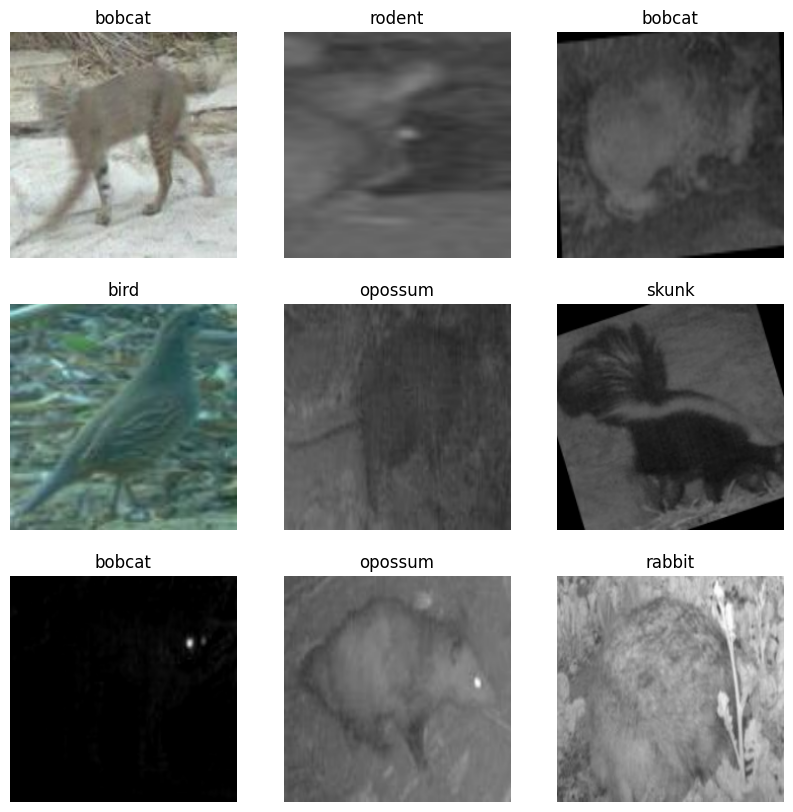

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Justificación del enfoque experimental

Aunque hemos preparado un dataset con casi 20k recortes, sigue siendo **relativamente pequeño** para entrenar redes neuronales profundas (DNNs) desde cero. Sería idóneo utilizar otras arquitecturas.

¿Por qué?

- Modelos como ResNet, EfficientNet o Vision Transformers se entrenan sobre datasets enormes como **ImageNet** (1M+ imágenes).
- Las DNNs requieren grandes volúmenes de datos para evitar underfitting y aprender desde patrones básicos (bordes) hasta complejos (formas).
- En datasets pequeños, la práctica común es usar **transfer learning**, aprovechando pesos preentrenados y ajustando solo las capas finales.

### Referencias relevantes
- [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks (arXiv)](https://arxiv.org/abs/1905.11946)  
- [Deep Residual Learning for Image Recognition — ResNet (arXiv)](https://arxiv.org/abs/1512.03385)  
- [Keras Applications: ResNet Models (Keras.io)](https://keras.io/api/applications/resnet/)  
- [TensorFlow Tutorial: Transfer Learning (TensorFlow.org)](https://www.tensorflow.org/tutorials/images/transfer_learning?hl=es-419)  
- [CS231n Stanford Lecture 17: Transfer Learning and Domain Adaptation (PDF)](https://cs231n.stanford.edu/slides/2021/lecture_17.pdf)

---

Sin embargo, antes de saltar al transfer learning, comprobaremos **empíricamente** qué rendimiento podemos lograr construyendo una CNN sencilla desde cero.

Esto nos dará:
- Una línea base de rendimiento.  
- Comprensión de las limitaciones del entrenamiento puro.  
- Datos para justificar (o no) el uso de modelos preentrenados.

---

**Próximo paso:**  
Construiremos y entrenaremos una CNN simple sobre nuestro dataset y analizaremos los resultados antes de decidir si migrar a transferencia.


In [10]:
from tensorflow.keras import layers, models

In [12]:
img_height = 224
img_width = 224
batch_size = 32
epochs = 20
num_classes = len(class_names)

In [16]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [20]:
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),


    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [21]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,171,404 (42.62 MB)

 Trainable params: 11,170,956 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [23]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[earlystop_callback]
)

Epoch 1/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 403s 803ms/step - accuracy: 0.2463 - loss: 20.2863 - val_accuracy: 0.2239 - val_loss: 2.4814
Epoch 2/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 378s 761ms/step - accuracy: 0.2228 - loss: 3.0947 - val_accuracy: 0.2665 - val_loss: 2.1480
Epoch 3/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 387s 780ms/step - accuracy: 0.2435 - loss: 2.3733 - val_accuracy: 0.2506 - val_loss: 4.1784
Epoch 4/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 385s 775ms/step - accuracy: 0.2533 - loss: 2.3134 - val_accuracy: 0.2774 - val_loss: 2.9400
Epoch 5/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 381s 768ms/step - accuracy: 0.2584 - loss: 2.1813 - val_accuracy: 0.2708 - val_loss: 2.1100
Epoch 6/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 385s 777ms/step - accuracy: 0.2652 - loss: 2.1524 - val_accuracy: 0.2877 - val_loss: 2.1066
Epoch 7/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 392s 790ms/step - accuracy: 0.2598 - loss: 2.1828 - val_accuracy: 0.2988 - val_loss: 2.1902
Epoch 8/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 373s 751ms/step - accuracy: 0.2639 

In [35]:
def plot_training_history(history, title_prefix=""):
    """
    Grafica loss y accuracy de entrenamiento y validación.
    
    Args:
        history: history object (keras.callbacks.History) después de model.fit().
        title_prefix: (opcional) texto para añadir al inicio de los títulos de las gráficas.
    """
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'{title_prefix} Loss: Train vs Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title(f'{title_prefix} Accuracy: Train vs Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

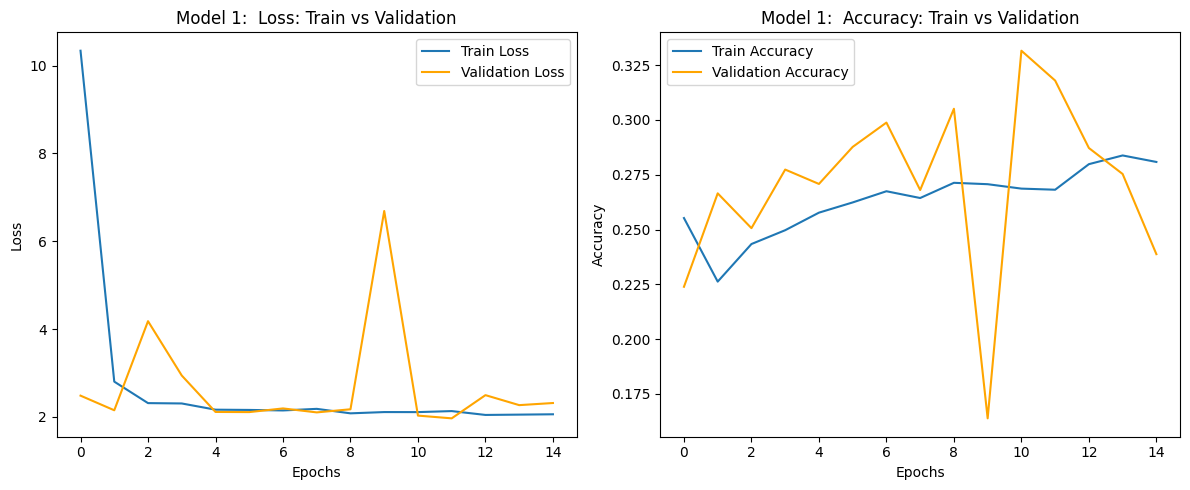

In [34]:
plot_training_history(history, title_prefix="Model 1: ")

Diagnóstico

- El modelo ya tocó su límite de aprendizaje.
- No hay mejora significativa con más epochs.
- Hay alta varianza en validación; podría ser underfitting, mala arquitectura, o ambos.

---

> Seguir con esta arquitectura, solo si disponemos de más datos

### Aumentando dataset

In [16]:
from vision.config import DATALOADER, ANNOTATIONS

In [17]:
import json
import pandas as pd
import os

In [18]:
json_files = [
    'cis_test_annotations.json',
    'cis_val_annotations.json',
    'trans_test_annotations.json',
    'trans_val_annotations.json',
    'train_annotations.json'
]

In [19]:
from tqdm import tqdm

In [20]:
def load_and_merge_annotations(base_path, json_files):
    merged_dfs = []

    for file in tqdm(json_files, desc="Processing JSON files"):
        file_path = os.path.join(base_path, file)
        with open(file_path, 'r') as f:
            data = json.load(f)

        images_df = pd.DataFrame(data['images'])
        categories_df = pd.DataFrame(data['categories'])
        annotations_df = pd.DataFrame(data['annotations'])

        merged_df = annotations_df.merge(
            images_df, left_on='image_id', right_on='id', suffixes=('_ann', '_img')
        )
        merged_df = merged_df.merge(
            categories_df, left_on='category_id', right_on='id', suffixes=('', '_cat')
        )

        merged_dfs.append(merged_df)
    
    final_df = pd.concat(merged_dfs, ignore_index=True)
    return final_df
    

In [21]:
combined_df = load_and_merge_annotations(ANNOTATIONS, json_files)

Processing JSON files: 100%|██████████| 5/5 [00:00<00:00,  7.77it/s]


In [22]:
combined_df.head()

,image_id,category_id,id_ann,bbox,file_name,rights_holder,height,width,frame_num,date_captured,location,seq_num_frames,seq_id,id_img,id,name
0,5a263af8-23d2-11e8-a6a3-ec086b02610b,30,343db02b-7d5b-11e7-884d-7845c41c2c67,NaN,5a263af8-23d2-11e8-a6a3-ec086b02610b.jpg,Justin Brown,1494,2048,2,2012-01-29 12:35:56,38,3,6f026d3d-5567-11e8-960a-dca9047ef277,5a263af8-23d2-11e8-a6a3-ec086b02610b,30,empty
1,5971faf4-23d2-11e8-a6a3-ec086b02610b,30,343db02c-7d5b-11e7-884d-7845c41c2c67,NaN,5971faf4-23d2-11e8-a6a3-ec086b02610b.jpg,Justin Brown,1494,2048,1,2012-01-23 16:56:32,38,3,6f025d61-5567-11e8-85d1-dca9047ef277,5971faf4-23d2-11e8-a6a3-ec086b02610b,30,empty
2,59ffbd00-23d2-11e8-a6a3-ec086b02610b,1,36132,"[1118.72, 570.88, 328.96000000000004, 180.4800...",59ffbd00-23d2-11e8-a6a3-ec086b02610b.jpg,Justin Brown,1494,2048,1,2012-02-11 01:48:19,38,3,6f0298b8-5567-11e8-8804-dca9047ef277,59ffbd00-23d2-11e8-a6a3-ec086b02610b,1,opossum
3,599d7b4a-23d2-11e8-a6a3-ec086b02610b,1,11320,"[513.28, 500.47999999999996, 153.6000000000000...",599d7b4a-23d2-11e8-a6a3-ec086b02610b.jpg,Justin Brown,1494,2048,3,2012-02-01 12:24:08,38,3,6f0278ba-5567-11e8-8041-dca9047ef277,599d7b4a-23d2-11e8-a6a3-ec086b02610b,1,opossum
4,599fbfe7-23d2-11e8-a6a3-ec086b02610b,30,343db02f-7d5b-11e7-884d-7845c41c2c67,NaN,599fbfe7-23d2-11e8-a6a3-ec086b02610b.jpg,Justin Brown,1494,2048,2,2012-02-08 03:21:39,38,3,6f028e68-5567-11e8-a478-dca9047ef277,599fbfe7-23d2-11e8-a6a3-ec086b02610b,30,empty


In [23]:
from vision.dataset import rescale_bounding_boxes

In [24]:
rescaled_df = rescale_bounding_boxes(combined_df, target_width=1024, target_height=747)
rescaled_df[['file_name', 'bbox_scaled']].head()

,file_name,bbox_scaled
0,5a263af8-23d2-11e8-a6a3-ec086b02610b.jpg,None
1,5971faf4-23d2-11e8-a6a3-ec086b02610b.jpg,None
2,59ffbd00-23d2-11e8-a6a3-ec086b02610b.jpg,"[559.36, 285.44, 164.48000000000002, 90.240000..."
3,599d7b4a-23d2-11e8-a6a3-ec086b02610b.jpg,"[256.64, 250.23999999999998, 76.80000000000001..."
4,599fbfe7-23d2-11e8-a6a3-ec086b02610b.jpg,None


In [25]:
from vision.plots import show_random_image_with_bbox, show_image_with_multi_bbox
from vision.config import RAW

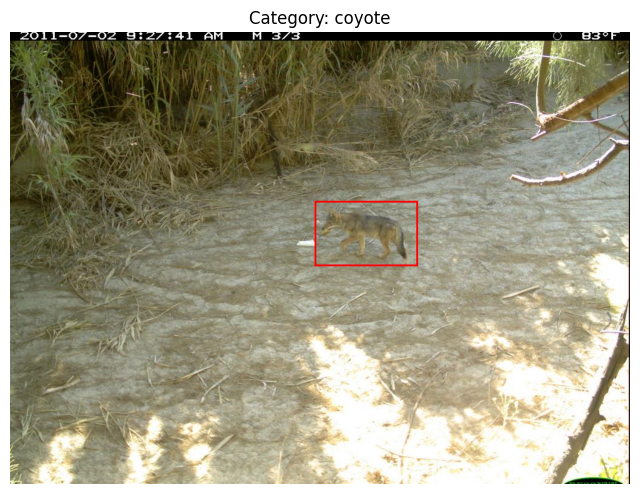

In [45]:
show_random_image_with_bbox(rescaled_df, RAW)

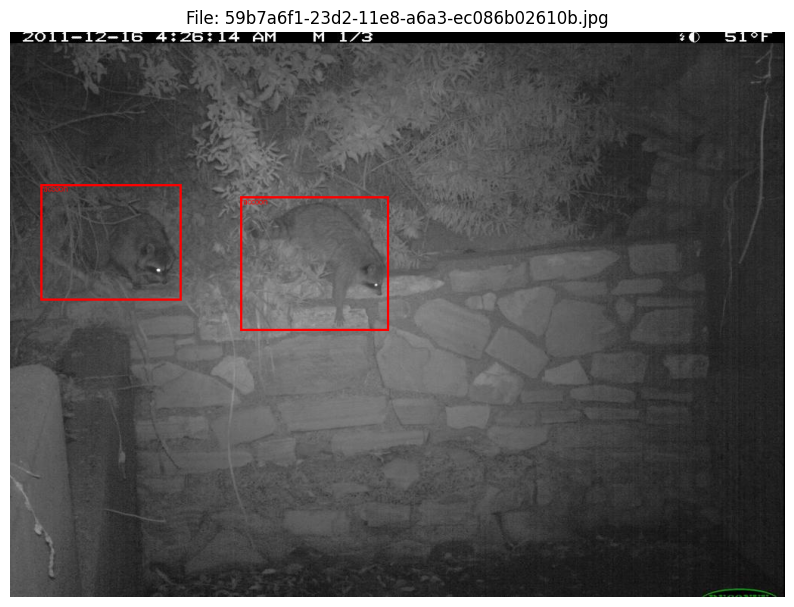

In [48]:
show_image_with_multi_bbox(rescaled_df, RAW)

In [49]:
valid_df = rescaled_df[rescaled_df['bbox_scaled'].notnull()]
class_counts = valid_df['name'].value_counts()
class_counts

name
opossum     11970
raccoon      7076
rabbit       4995
coyote       4700
bobcat       4320
cat          4303
dog          2641
car          2613
squirrel     2479
bird         1579
skunk         722
rodent        482
deer          186
badger         29
fox             8
Name: count, dtype: int64

### Análisis de balance de clases
Además de excluir `fox`, `badger` y `deer` por bajo número de ejemplos, será bueno también excluir `rodent` (218) y `skunk` (508), porque siguen siendo muy minoritarios frente a las clases principales.

También se aplicara *data augmentation*

In [50]:
from vision.dataset import save_recortes_by_class
from vision.config import RAW, CLIPS

In [51]:
save_recortes_by_class(valid_df, RAW, CLIPS)

Saving crops: 100%|██████████| 48103/48103 [20:41<00:00, 38.73it/s]


In [52]:
from vision.dataset import count_files_per_class

In [53]:
counts = count_files_per_class(CLIPS)
counts

{'opossum': 11970,
 'raccoon': 7076,
 'rabbit': 4995,
 'coyote': 4700,
 'bobcat': 4320,
 'cat': 4303,
 'dog': 2641,
 'car': 2613,
 'squirrel': 2479,
 'bird': 1579,
 'skunk': 722,
 'rodent': 482,
 'deer': 186,
 'badger': 29,
 'fox': 8}

Clases a excluir: fox, badger, deer, rodent, skunk

además...

In [54]:
from vision.plots import show_random_image_by_class

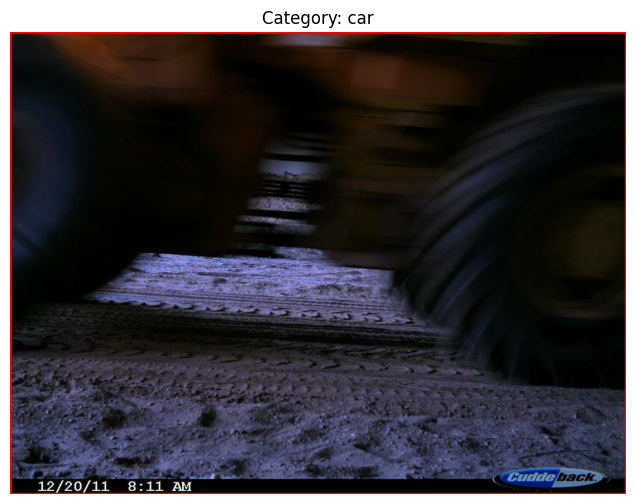

In [55]:
show_random_image_by_class(valid_df, 'car', RAW)

En datasets de fauna (como cámaras trampa) es común encontrar categorías “no-animal”
como car, human, vegetation, etc.

¿Por qué? Porque esos elementos aparecen accidentalmente en el entorno.

--- 

Conviene mantener clases distractoras (como car, human, etc.)
porque enseñan al modelo a diferenciar fauna de objetos no relevantes,
evitando falsos positivos y mejorando la generalización.

---

Aplicando transformaciones

In [61]:
import albumentations as A

In [62]:
augment_dog_car_squirrel = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Affine(translate_percent=0.05, scale=1.1, rotate=10, p=0.4),
    A.GaussNoise(p=0.3),
])


In [63]:
augment_bird = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.Rotate(limit=20, p=0.6),
    A.Affine(translate_percent=0.1, scale=1.2, rotate=15, p=0.5),
    A.GaussNoise(p=0.4),
    A.Blur(blur_limit=3, p=0.2),
])

In [64]:
from vision.dataset import apply_augmentations_for_class

In [65]:
from vision.config import AUGMENTED

In [66]:
apply_augmentations_for_class('dog', CLIPS, AUGMENTED, augment_dog_car_squirrel, num_augmentations=2)
apply_augmentations_for_class('car', CLIPS, AUGMENTED, augment_dog_car_squirrel, num_augmentations=2)
apply_augmentations_for_class('squirrel', CLIPS, AUGMENTED, augment_dog_car_squirrel, num_augmentations=2)
apply_augmentations_for_class('bird', CLIPS, AUGMENTED, augment_bird, num_augmentations=4)

Augmenting bird: 100%|██████████| 1579/1579 [00:27<00:00, 56.97it/s]


Encapsulamos únicamente las clases que tienen una muestra representativa

In [67]:
allowed_classes = [
    'opossum', 'rabbit', 'coyote', 'cat', 'squirrel', 'raccoon', 
    'dog', 'bobcat', 'car', 'bird'
    # NOTA: ahora estamos excluyendo fox, badger, deer, rodent, skunk
]

In [70]:
import shutil
import random

In [71]:
split_ratio = 0.25  # 25% valid, 75% train

In [74]:
for class_name in allowed_classes:
    src_dir = os.path.join(CLIPS, class_name)
    train_dir = os.path.join(DATALOADER, 'train', class_name)
    valid_dir = os.path.join(DATALOADER, 'valid', class_name)

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(valid_dir, exist_ok=True)

    if not os.path.exists(src_dir):
        print(f"La carpeta {src_dir} no existe, saltando...")
        continue

    files = [f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))]
    random.shuffle(files)

    n_valid = int(len(files) * split_ratio)
    valid_files = files[:n_valid]
    train_files = files[n_valid:]

    for f in tqdm(train_files, desc=f"{class_name} - train", leave=True):
        src = os.path.join(src_dir, f)
        dst = os.path.join(train_dir, f)
        shutil.copy2(src, dst)

    for f in tqdm(valid_files, desc=f"{class_name} - valid", leave=True):
        src = os.path.join(src_dir, f)
        dst = os.path.join(valid_dir, f)
        shutil.copy2(src, dst)

print("Distribución train/valid completada.")

bird - valid: 100%|██████████| 394/394 [00:04<00:00, 92.12it/s] 

Distribución train/valid completada.


In [77]:
from vision.config import TRAIN, VALID

In [78]:
counts = count_files_per_class(TRAIN)
counts

{'opossum': 8978,
 'raccoon': 5307,
 'rabbit': 3747,
 'coyote': 3525,
 'bobcat': 3240,
 'cat': 3228,
 'dog': 1981,
 'car': 1960,
 'squirrel': 1860,
 'bird': 1185}

In [79]:
counts = count_files_per_class(VALID)
counts

{'opossum': 2992,
 'raccoon': 1769,
 'rabbit': 1248,
 'coyote': 1175,
 'bobcat': 1080,
 'cat': 1075,
 'dog': 660,
 'car': 653,
 'squirrel': 619,
 'bird': 394}

In [ ]:
from vision.config import AUGMENTED

In [82]:
counts = count_files_per_class(AUGMENTED)
counts

{'bird': 6316, 'dog': 5282, 'car': 5226, 'squirrel': 4958}

In [80]:
for cls in allowed_classes:
    augmented_dir = os.path.join(AUGMENTED, cls)
    train_dir = os.path.join(TRAIN, cls)
    os.makedirs(train_dir, exist_ok=True)
    
    if os.path.exists(augmented_dir):
        for fname in tqdm(os.listdir(augmented_dir), desc=f"{cls} - augmented", leave=True):
            src = os.path.join(augmented_dir, fname)
            dst = os.path.join(train_dir, fname)
            shutil.copy2(src, dst)

bird - augmented: 100%|██████████| 6316/6316 [00:52<00:00, 119.78it/s]


In [81]:
counts = count_files_per_class(TRAIN)
counts

{'opossum': 8978,
 'bird': 7501,
 'dog': 7263,
 'car': 7186,
 'squirrel': 6818,
 'raccoon': 5307,
 'rabbit': 3747,
 'coyote': 3525,
 'bobcat': 3240,
 'cat': 3228}

### **Problemas del modelo actual**

- Parte de cero → aprende bordes, texturas y patrones sin conocimiento previo.
- Capacidad limitada → no captura la complejidad de fauna salvaje (variaciones de especies, fondos, luz).
- Requiere muchos más datos y epochs para alcanzar niveles competitivos.

---

*Recomendación*
- Cambiar a un modelo preentrenado (EfficientNetB0 o ResNet50) con fine-tuning.
- Incorporar class_weights para compensar el desbalance entre clases.
- Aplicar augmentations para enriquecer las clases minoritarias.
- Considerar optimizaciones como learning rate scheduler.


In [4]:
img_height = 224
img_width = 224
batch_size = 32

In [10]:
from vision.config import DATALOADER, ANNOTATIONS

WindowsPath('D:/python/annotations-deeplearning/data/annotations')

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATALOADER,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATALOADER,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 19833 files belonging to 12 classes.
Using 15867 files for training.
Found 19833 files belonging to 12 classes.
Using 3966 files for validation.


In [8]:
val_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [9]:
class_names = train_ds.class_names
print(class_names)

['bird', 'bobcat', 'car', 'cat', 'coyote', 'dog', 'opossum', 'rabbit', 'raccoon', 'rodent', 'skunk', 'squirrel']
